In [1]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

sys.path.append('/user_data/mmhender/imStat/code/')
import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'alexnet_Conv5_plus_sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/alexnet_Conv5_plus_sketch_tokens/Oct-22-2021_1917_45/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'alexnet_layer_name'])
subject = 1
volume_space = 1
fitting_type = alexnet
fitting_type2 = sketch_tokens
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (30000,)
voxel_index: len 1
voxel_roi: len 4
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_range = 1.1
models: shape (875, 3)
best_losses: shape (19738, 3)
best_lambdas: shape (19738, 3)
best_params: len 6
lambdas: shape (9,)
val_cc: shape (19738, 3

In [3]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [4]:

port=33333

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names0 = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps0 = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps0 = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins0 = [0,0,0]
maxes0 = [7, 360, 4]

In [5]:
bad_voxels = out['val_r2'][:,0]<0

pp0 = 0
pp1 = 1
pp2 = 2

val_r2 = out['val_r2']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])
var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)
var_expl[bad_voxels,:] = np.nan

max_ind = (np.argmax(var_expl[:,1:3], axis=1)+1).astype(np.float32)
max_ind[bad_voxels] = np.nan

maps1 = [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(4)] + [copy.deepcopy(max_ind)]

names1 = ['Full model (Alexnet+ST)','Unique var: Alexnet', 'Unique var: ST', 'Shared', \
          'Unique var greater for Alexnet or ST']
cmaps1 = ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins1 = [0, 0, 0, 0, 0]
maxes1 = [0.8, 0.8, 0.8, 0.8, 3]

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


In [6]:
# maps = maps0+maps1+maps2+maps3
# cmaps=cmaps0+cmaps1+cmaps2+cmaps3
# names=names0+names1+names2+names3
# mins=mins0+mins1+mins2+mins3
# maxes=maxes0+maxes1+maxes2+maxes3

maps = maps0+maps1
cmaps=cmaps0+cmaps1
names=names0+names1
mins=mins0+mins1
maxes=maxes0+maxes1

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333
Stopping server


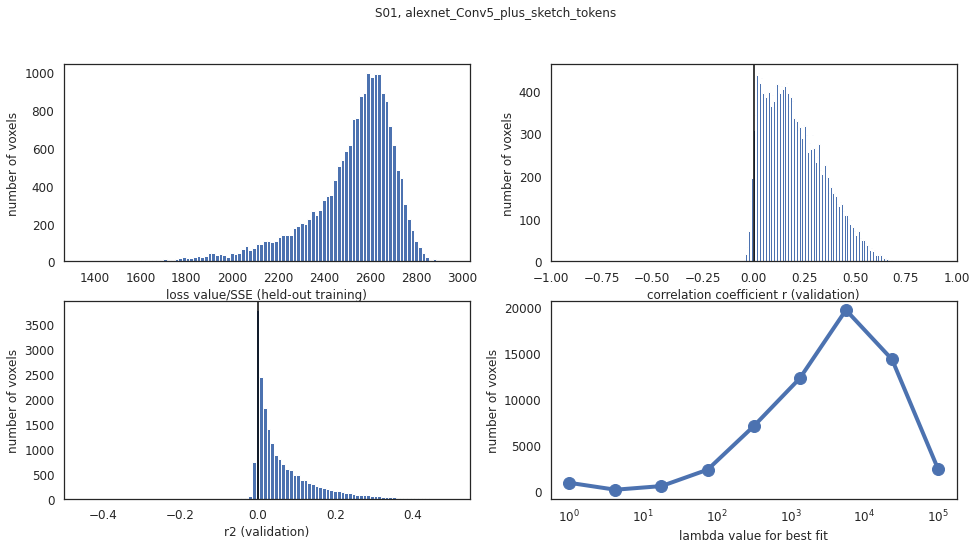

In [21]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

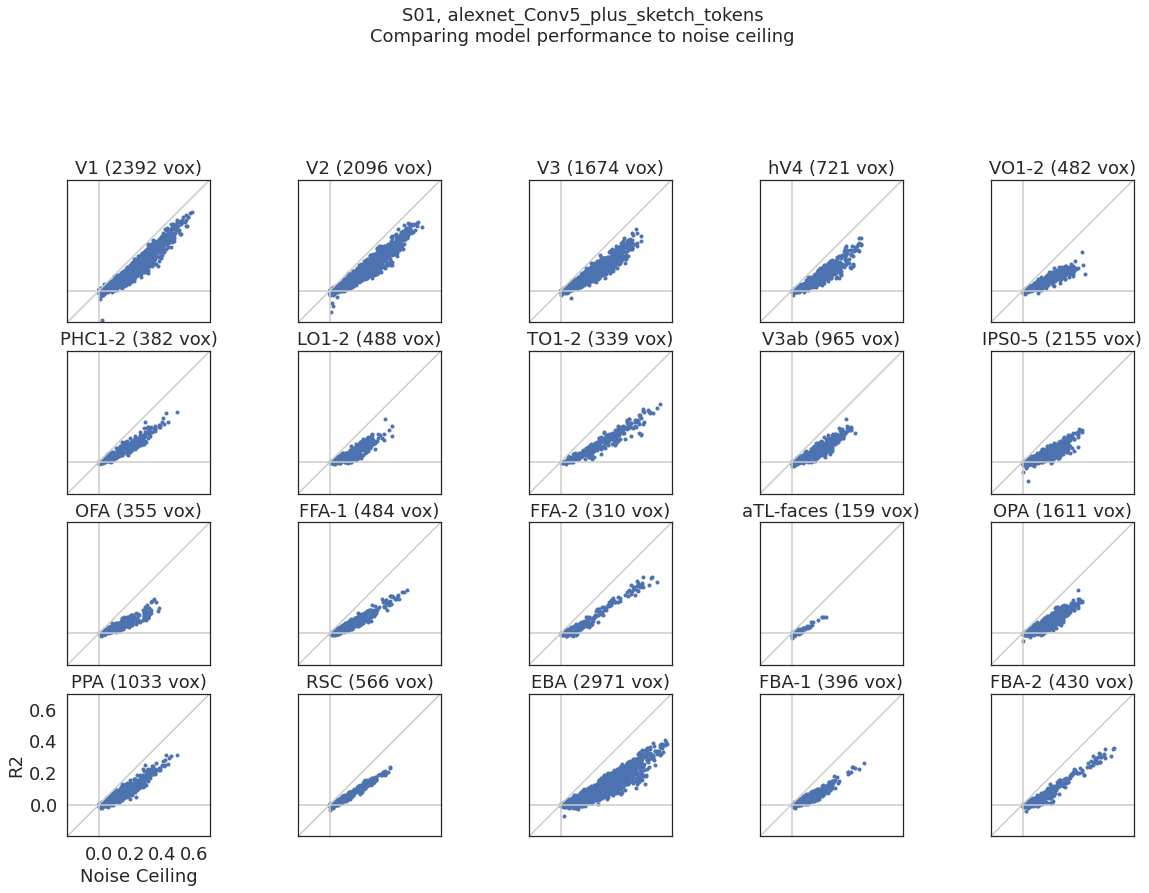

In [6]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,0])*out['val_cc'][:,0]**2
val_r2 = out['val_r2'][:,0]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size, roi_def=roi_def, skip_inds=skip_inds)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_concat_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_concat_vs_noiseceiling.pdf'))



In [ ]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,0])*out['val_cc'][:,0]**2
val_r2 = out['val_r2'][:,2]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size, roi_def=roi_def, skip_inds=skip_inds)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_concat_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_concat_vs_noiseceiling.pdf'))



In [8]:
out['partial_version_names']

['full_combined_model', 'just_alexnet', 'just_sketch_tokens']

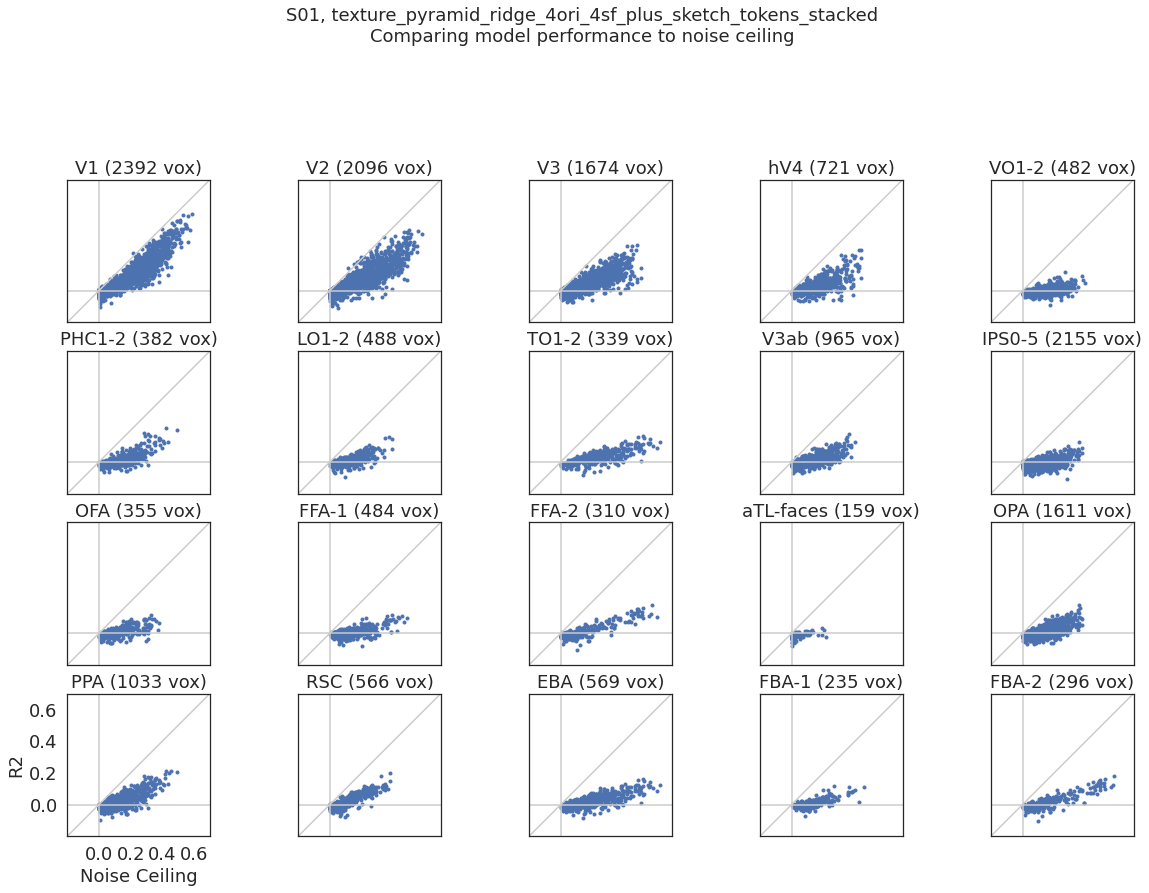

In [15]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,1])*out['val_cc'][:,1]**2
val_r2 = out['val_r2'][:,1]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size, roi_def=roi_def, skip_inds=skip_inds)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_textureonly_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_textureonly_vs_noiseceiling.pdf'))



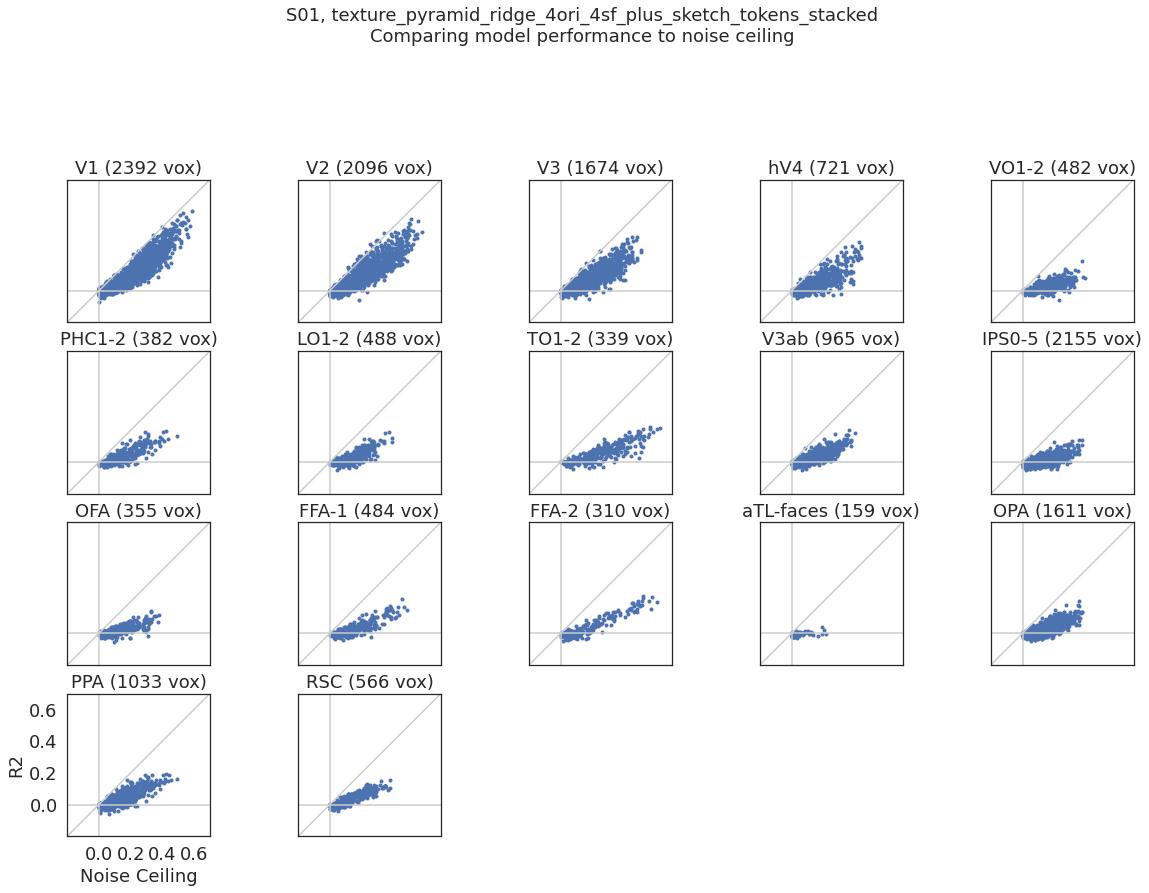

In [5]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,0])*out['val_cc'][:,0]**2
val_r2 = out['val_r2'][:,6]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_STonly_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_STonly_vs_noiseceiling.pdf'))



In [22]:
np.array(out['partial_version_names'])[[5,4,1]]

array(['pyramid_texture_just_higher-level_plus_other_modules',
       'pyramid_texture_just_lower-level_plus_other_modules',
       'just_pyramid_texture'], dtype='<U52')

In [30]:
np.array(out['partial_version_names'])[[0,1,6]]

array(['full_combined_model', 'just_pyramid_texture',
       'just_sketch_tokens'], dtype='<U52')

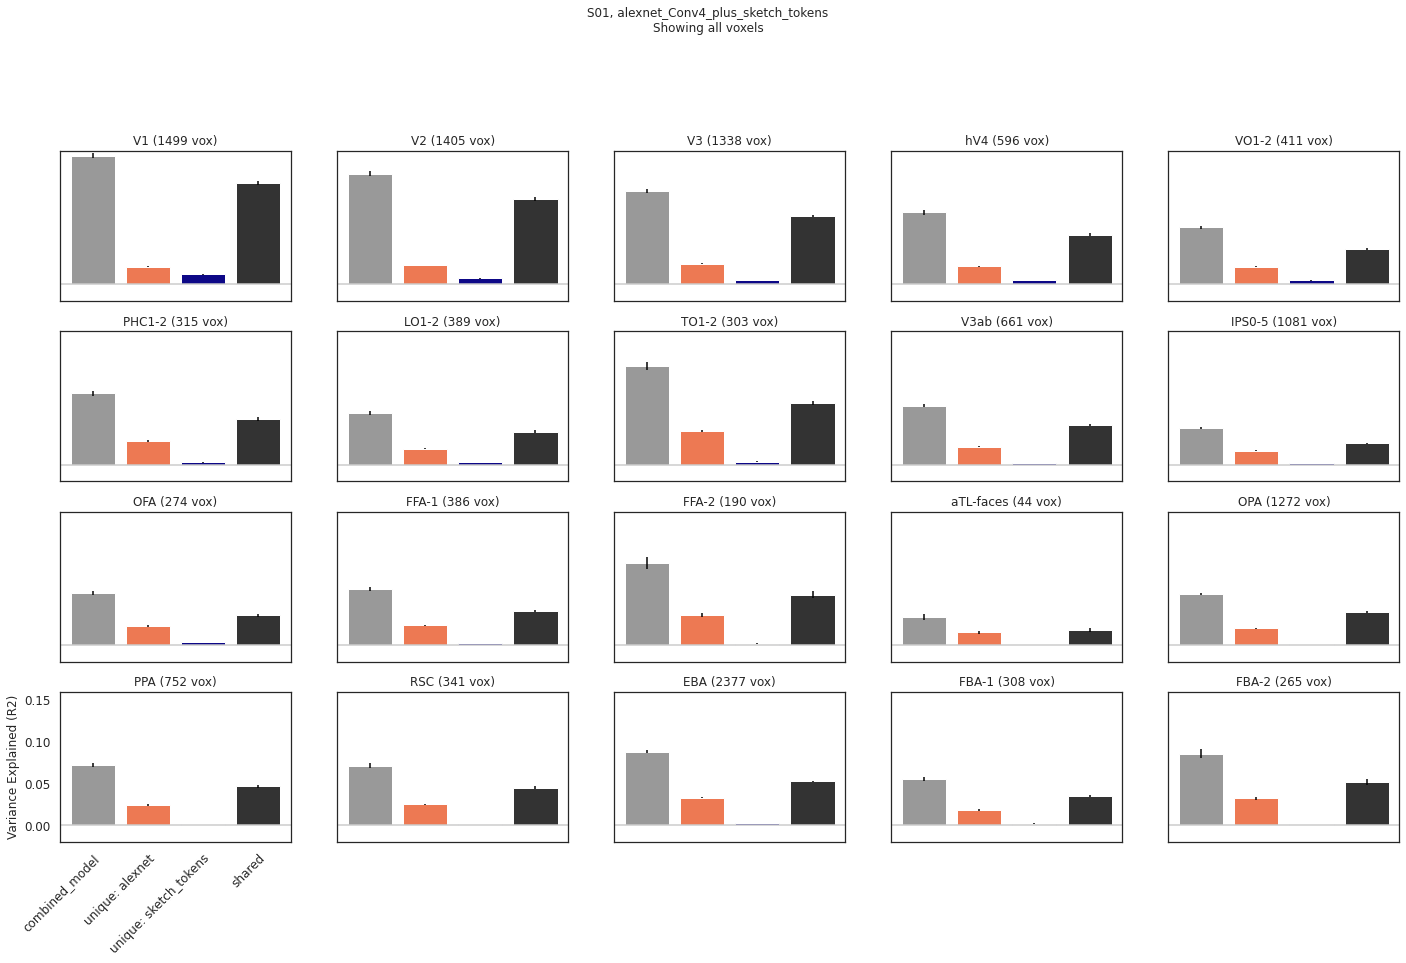

In [43]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
# val_r2 = analysis_utils.get_r2(out)
val_r2 = out['val_r2']
# val_r2 = np.sign(out['val_cc'])*out['val_cc']**2

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.16])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_bars_eachroi.pdf'))
#     plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_bars_eachroi.png'))

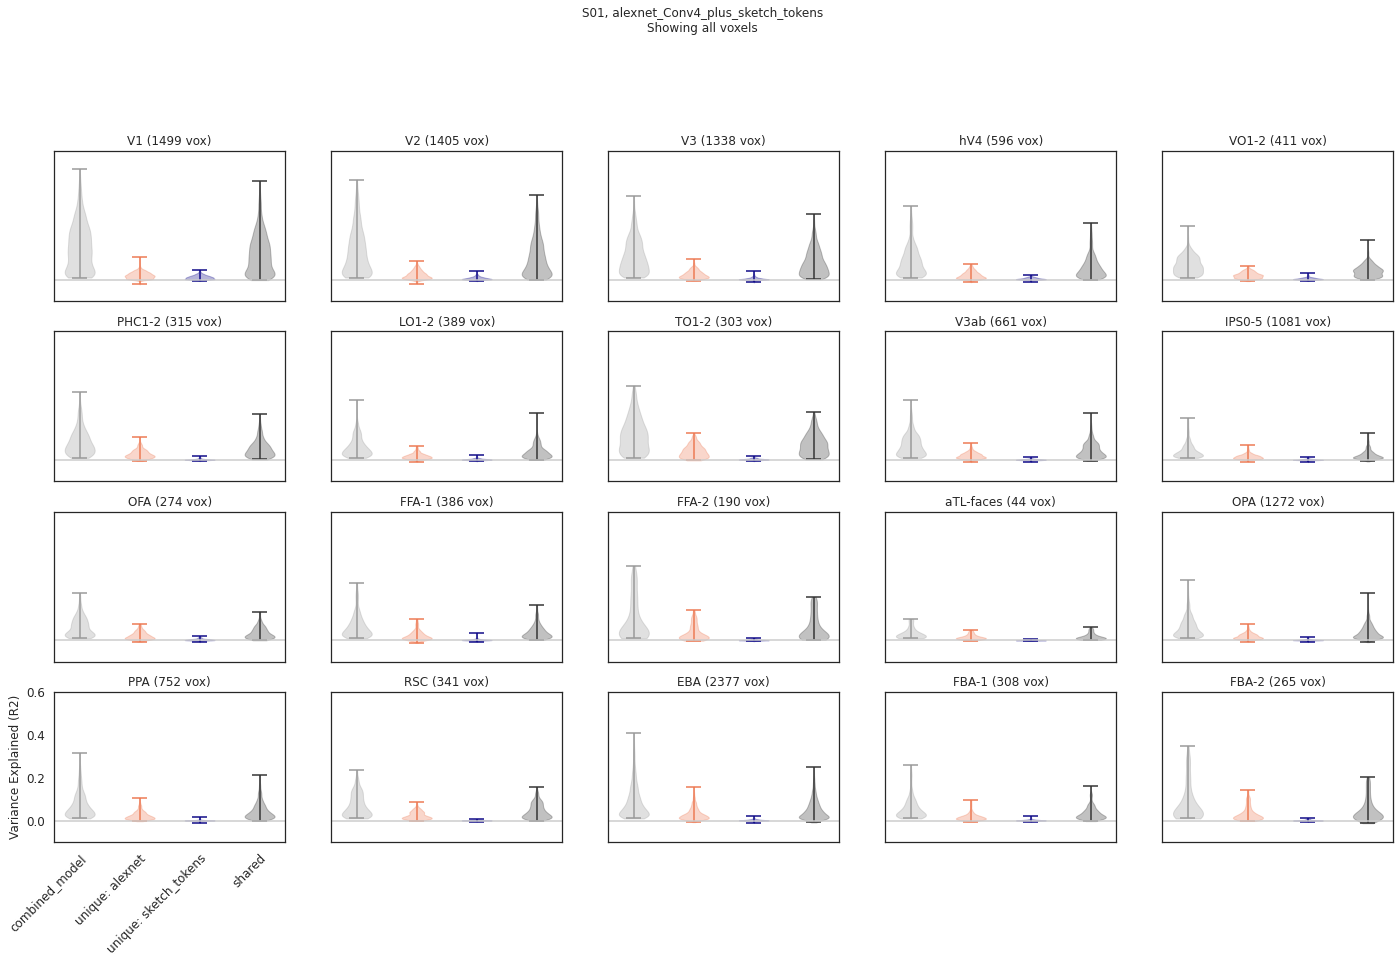

In [44]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
# val_r2 = analysis_utils.get_r2(out)
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.10, 0.60])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, roi_def=roi_def, skip_inds=skip_inds, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varpart_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varpart_violin_eachroi.png'))

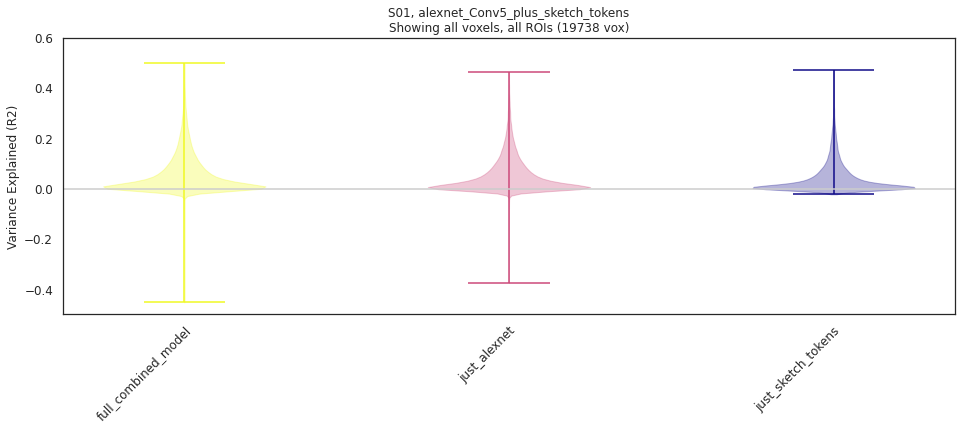

In [33]:
# All individual models, and concat models. 

n_partial_versions = out['partial_masks'].shape[0]
val_cc = out['val_cc']
var_expl = out['val_r2']
ve_names = out['partial_version_names']

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.5, 0.6])
vp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_each_submodel_violin_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'r2_each_submodel_violin_allrois.png'))

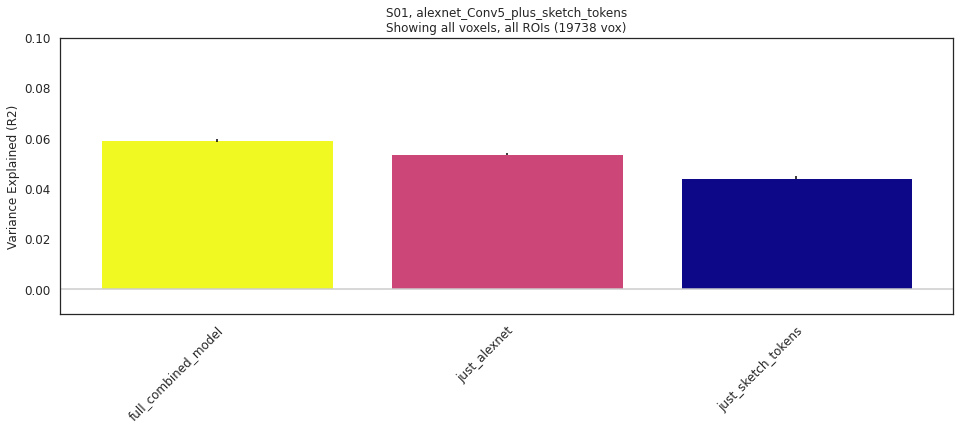

In [36]:

n_partial_versions = out['partial_masks'].shape[0]
var_expl = out['val_r2']
ve_names = out['partial_version_names']

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.10])
bp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_each_submodel_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'r2_each_submodel_allrois.png'))